In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\jecroisp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [63]:

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns


In [64]:
df = pd.read_csv('../data/apriori_data.csv')

In [65]:
# Drop the index column
df.drop(columns=["Unnamed: 0"], inplace=True)

# Fix problematic feature names for XGBoost
df.columns = df.columns.str.replace(r"[\[\]<>]", "_", regex=True)


In [66]:
X = df.drop(columns=["Price"])
y = df["Price"]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
dt = DecisionTreeRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

In [69]:
dt.fit(X_train_scaled, y_train)


DecisionTreeRegressor(random_state=42)

In [70]:
model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", list(selected_features))


Selected Features by RFE: ['Make', 'Model', 'Year', 'Cylinders', 'Fuel Type', 'Rank', 'Price_bin=40k+', 'Other=0.0 & Price_bin=40k+', 'Fuel Type=2.0 & Other=0.0 & Transmission=1.0', 'Other=0.0 & Transmission=1.0 & Year_bin=_1990']


In [72]:
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [73]:
joblib.dump(dt, "decision_tree_model.pkl")
joblib.dump(rfe, "random_forest_model.pkl")
joblib.dump(xgb, "xgboost_model.pkl")


['xgboost_model.pkl']

In [74]:
stacking = StackingRegressor(
estimators=[
('rf', RandomForestRegressor(random_state=42)),
('gb', DecisionTreeRegressor(random_state=42)),
('xgb', XGBRegressor(random_state=42))
],
final_estimator=LinearRegression()
)
voting = VotingRegressor(
estimators=[
('rf', RandomForestRegressor(random_state=42)),
('gb', DecisionTreeRegressor(random_state=42)),
('xgb', XGBRegressor(random_state=42))
]
)

In [75]:
def evaluate_model(model, X_train, y_train, X_test, y_test, show_plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²:  {r2:.2f}")
    
    if show_plot:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.title(f"Actual vs Predicted: {model.__class__.__name__}")
        plt.tight_layout()
        plt.show()

    return y_pred


Model: RFE
MSE: 80569452829.93
MAE: 102725.73
R²:  0.69


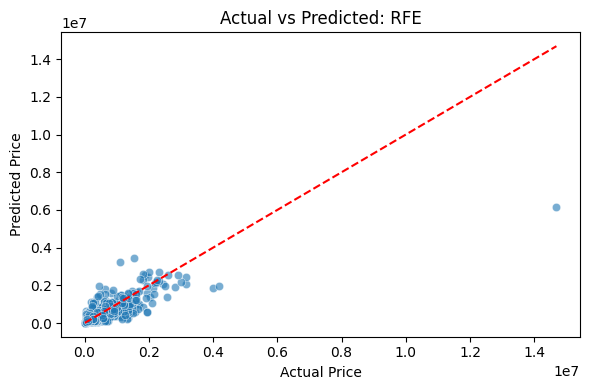

In [76]:
y_preds_rf = evaluate_model(rfe, X_train_scaled, y_train, X_test_scaled, y_test)



Stacking Regressor Performance:

Model: StackingRegressor
MSE: 68752489494.23
MAE: 102228.25
R²:  0.74


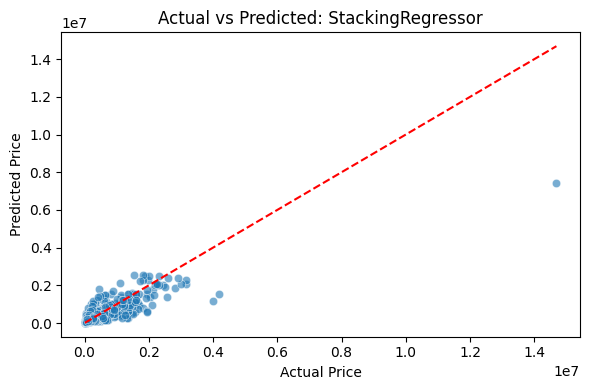

In [77]:
print("\nStacking Regressor Performance:")
y_pred_stacking = evaluate_model(stacking, X_train, y_train, X_test, y_test)


Voting Regressor Performance:

Model: VotingRegressor
MSE: 74280730623.72
MAE: 103150.46
R²:  0.72


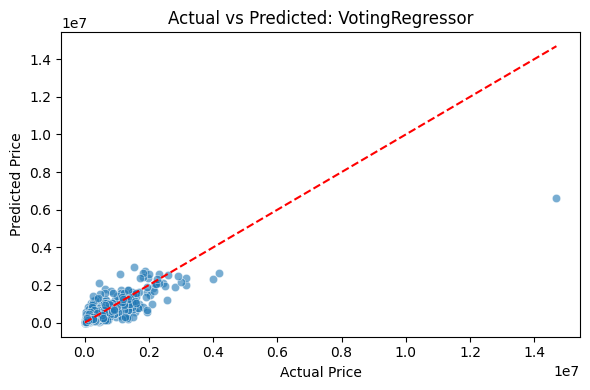

In [78]:
print("\nVoting Regressor Performance:")
y_pred_voting = evaluate_model(voting, X_train, y_train, X_test, y_test)

In [79]:
from sklearn.model_selection import cross_val_score

In [80]:
print("\nCross-Validation (Random Forest):")
scores = cross_val_score(RandomForestRegressor(random_state=42), X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Average R² Score:", np.mean(scores))


Cross-Validation (Random Forest):
Cross-Validation R² Scores: [0.64361784 0.72769191 0.73726284 0.67418005 0.77036211]
Average R² Score: 0.710622949788416
